# Installing FastAI in our Google Colab environment


In [1]:
!pip install --upgrade pip && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 719 kB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 342 kB 65.4 MB/s 
     |████████████████████████████████| 197 kB 74.0 MB/s 
     |████████████████████████████████| 1.2 MB 53.7 MB/s 
     |████████████████████████████████| 4.2 MB 46.3 MB/s 
     |████████████████████████████████| 59 kB 8.8 MB/s 
     |████████████████████████████████| 1.1 MB 57.7 MB/s 
     |████████████████████████████████| 212 kB 72.9 MB/s 
     |████████████████████████████████| 136 kB 66.2 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 127 kB 74.3 MB/s 
     |████████████████████████████████| 271 kB 72.2 MB/s 
     |████████████████████████████████| 144 kB 60.2 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
     |████████████████████████████████| 6.6 MB 51.6 MB/s 
     |████████████████████████████████| 596 kB 63.0 MB/s 
ERROR: pip's dependency resolver does not currently take into accoun

# Lesson 1 Coding Exercise - Build a Birds Classifier
Resources from the lesson:
* Here's the [Lesson 1 lecture](https://youtu.be/xRDX8L55CYA?list=PLP3ShvPz06yyYnuIxOR1dzl7KdmacCRG-) on YouTube.
* [Here is the point in the lecture where we start coding.](https://youtu.be/xRDX8L55CYA?list=PLP3ShvPz06yyYnuIxOR1dzl7KdmacCRG-&t=3842)
* Here's the [forum thread](https://forums.fast.ai/t/lesson-1-official-topic/95287) for the lesson.
* Here's [Jeremy's Kaggle notebook on building a bird classifier](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data).

The objective here is to use the FastAI library -- which, at this point in the course, you know nothing about, to build a deep learning model to determine whether an image is of a bird or not.  At this point, we're going to copy and execute (and explore) code from Jeremy's Kaggle notebook on buildilng a bird classifier (above).

In [2]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

## Step 1 - download images of birds and non-birds
We'll start by searching for "bird photos" -- and only one of them -- using the above convenience function.

In [3]:
urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.unsplash.com/photo-1535083783855-76ae62b2914e?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&w=1000&q=80'

Now, let's download the image and have a look at it.

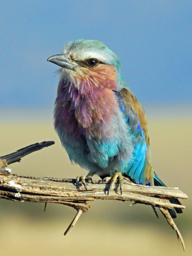

In [4]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Let's do the same thing for "forest photos" (and only one of them).

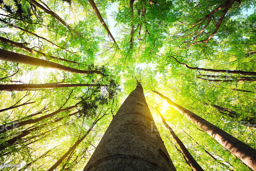

In [5]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

These searches seem to be giving reasonable results, so let's download 200 examples of each "bird" and "forest" photos, and save each group to a different folder.

In [6]:
searches = 'forest','bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

We're using 2 FAstAI library functions in the above:
* download_images()
* resize_images()

We generally don't need particularly large images for computer vision tasks, so we want to save the time that is spent opening large images.

## Step 2 - train our model
**Some** of these photos may not have downloaded properly, or may not be photos at all, so we'll work through that ...

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

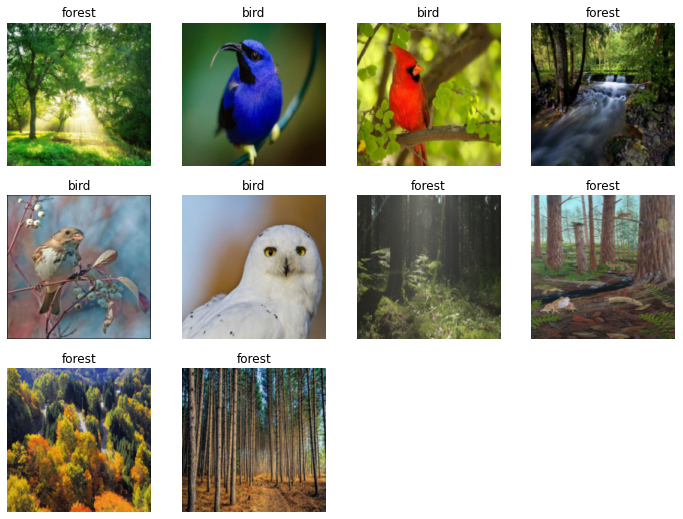

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=10)

As deep learning practitioners, we spend most of our time working to get our data into our models.  Understanding the `DataBlock` API is critical in accelerating your efficacy as a deep learning practitioner.  The `DataBlock` API has been created by answering this question:
> Over hundreds and hundreds of deep learning projects, what are the things that change, from project to project, to get the data into the right shape?

### The 6 questions we need to answer for FastAI to build a deep learning model
We answer these questions as we parameterize the `DataBlock` constructor call.  (This is a helpful way to explain to non-coders what we are doing when we pass parameters to a function ...)

1. What kind of **input** do we have?
  * There are lots of "blocks" in FastAI which answer this question, and we pass theses blocks to the `blocks=` parameter
  * In this case, our input is an image, so we use the `ImageBlock` block type
1. What kind of **output** should we produce (i.e. what kind of label)?
  * In this case, our output is a category, so we use the `CategoryBlock` block type
1. What are the **items** that this model will be working on?
  * In this case, our items are images, so we use the `get_image_files()` item getter
  * `get_image_files()` returns a list of all of the image files in a given path, based on the file extensions
1. How should I build my **validation set**?
  * In this case, we tell FastAI to randomly set aside 20% of our data using the `RandomSplitter()` function from the FastAI library
1. How do we know the correct label of an item?
  * In our case, our items are images, so we're telling FastAI how to determine what the correct label is for each image
  * We have built our dataset above so that the parent folder is the label that we want to use ("bird" and "forest", respectively)
  * This is common practice in machine learning, so FastAI includes a function for us to return the name of the parent folder `parent_label()`
1. How should we transform the items for GPU processing?
  * Most computer vision architectures need all of the inputs used in training to be the same size
  * We tell `item_tfms` all of these transformations
  * In this case, we use FastAI's `Resize()` function to resize every input image to 192 x 192 pixels
  * There are 2 ways to resize -- we can crop out a piece from the middle of the image, or squish the entire image -- to fit dimensions
  * We will squish the images

With that, we create the `DataBlock` object, and save its resulting `dataloaders`.

Data Loaders will feed the training algo -- via the GPU -- with a batch of your items (images) at once.  We can look at a batch of images using the `dls.show_batch()` method.

### Pro tip:  review the FastAI docs!
... to learn what kinds of labeling functions, and splitters, and blocks, etc ... there are to help with your deep learning projects.  Often the best place to go is the Tutorials section.

https://docs.fast.ai/tutorial.html

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

A critical concept in FastAI is a **learner**.  The learner requires 2 things as input:  the data (via our `dataloaders`) and the model (in our case, we'll use the `resnet18` pretrained model).

### Pro tip: use the `timm` library to build ANY of the PyTorch image models!
NB -- FastAI allows you to use **any** of the PyTorch image models via its integration to the `timm` library.  Documentation on the `timm` library can be found here:  https://timm.fast.ai/

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.772768,1.334107,0.328947,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.090478,0.107282,0.052632,00:02
1,0.054118,0.041557,0.013158,00:02
2,0.044796,0.021030,0.013158,00:02


Note, above, that FastAI has gone and downloaded a pretrained `resnet18` model (weights and biases) so that you're starting with a highly capable model, which only requires some "fine tuning" (`fine_tune()`) to your specific dataset.  Notice that after just 3 epochs of fine tuning, our model is ~99% accurate.

In [10]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.002775,0.008994,0.000000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.007228,0.002470,0.000000,00:02
1,0.003891,0.002318,0.000000,00:02
2,0.002712,0.001748,0.000000,00:02


Notice that after just another 3 epochs of fine tuning, our model is now 100% accurate in predicting a bird or not!

## Step 3 - use our newly built model (and also build your own)!
We can now use our model, built on the `resnet18` architecture, but specifically fine-tuned to our use case of recognizing birds or not.

Let's use the first bird image that we downloaded above.

In [11]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


## Summarizing what we've learned
The FastAI library simplifies deep learning down to 3 steps.

1. Get your data
  * In our case, we rolled a custom function, then used some FastAI functions, to search DuckDuckGo for images of both birds and forests
  * We put these images into folders called "bird" and "forest", respectively
1. Load your data into a `DataLoader`
  * In our case, we used the `DataBlock` API to create a `DataLoader` for the images that we downloaded
1. Build a `learner` using your DataLoader
  * We built a `vision_learner` using our DataLoader, based on a pretrained `resnet18` architecture, and fine tuned it a few times to retrain it to our specific dataset.